---

## 12.3 Neural style transfer

Reminder, to connect to your drive:

```python
import sys

# reminder: Colab code to mount your drive
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('drive/My Drive/IS53024B-Artificial-Intelligence/8-generative-deep-learning') # 'My Drive' is the default name of Google Drives,
    os.listdir()
```    

In [1]:
import os
import sys
import time
import pathlib

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import YouTubeVideo

import tensorflow as tf

The aim is to apply the *style* of one image to the *content* of another image.

- **Style**: textures, colours, visual patterns;
- **Content**: high level macrostructure.

#### van Gogh-like brushstrokes applied to a photograph

![style transfer](https://s3.amazonaws.com/book.keras.io/img/ch8/style_transfer.png)

<small>DLWP, p.383</small>

What we want is to **define a loss fuction** for what we wish to achieve and then minimise it.

In our case, we want:

```python
loss = (
    # 1. minimise the distance in style between two images
    distance(style(reference_image), style(generated_image))
    +
    # 2. minimise the distance in content between two images
    distance(content(original_image), content(generated_image))
    +
    # 3. minimise the variation (pixel to pixel change) of the image
    variation(generated_image)
)
```

The overall process will be:

1. We pass our content image and our style image to a **pretrained network**;
2. We will look at how our network reacts to both images:
    - in terms of content (content loss) and
    - in terms of style (style loss);
3. We will **learn the image**:  
    i.e. take the gradient of the combined loss and see how to change the image to lower it;
3. through the loss, we will enforce:
    - that the **content** are as close to the content image, and;
    - that the **style** are as close to the style image, as posssible.
    - that the **continuity** in the image is respected (hopefully avoiding pixelated results, DLWP p.388)

---

### 12.3.1 The content loss


We know that upper layers contain more *global* information – **macrostructure** or **content**.

We will compare the **activations** of the upper layer(s) of a pretrained ConvNet.

We pass both content and style image, and we look at the **same activation layers** for both.

The loss used to compare them is the **squared distance**.


---

### 12.3.2 The style loss

The aim is to capture the appearance of the target image at all spatial scales.

Style loss aims to preserve the **correlations** between activations of different layers.

The idea is that textures are represented as **correlations of features** at different scales.

---

### The variation loss

There also one final loss, which keeps in check the local variation of pixels in the generated image (works like a regulariser).

We shift the pixels by 1 in the width and in the height, add those (in effect: neighbours) and look at the total difference that this produces (we reduce that, forcing neighbours to be similar to each other).

---

### 12.3.3 Neural style transfer in Keras

1. Use a pretrained convnet e.g. **VGG19** (VGG16 + 3 extra conv. layers);
2. Compute the layer activations for the style-reference image and the original image *once* before the training loop;
3. During the loop, compute the activations for the generated image, and the losses;
3. Minimise the total loss with gradient descent (incrementally change the image).

**Getting the style and content images**

In [2]:
basedir = pathlib.Path("neural-style-transfer")
if not basedir.is_dir():
    os.mkdir(basedir)
    
base_image_path = tf.keras.utils.get_file(
    "sf.jpg",
    origin="https://img-datasets.s3.amazonaws.com/sf.jpg",
    cache_dir=basedir,
    cache_subdir="",
)
style_reference_image_path = tf.keras.utils.get_file(
    "starry_night.jpg",
    origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg",
    cache_dir=basedir,
    cache_subdir="",
)

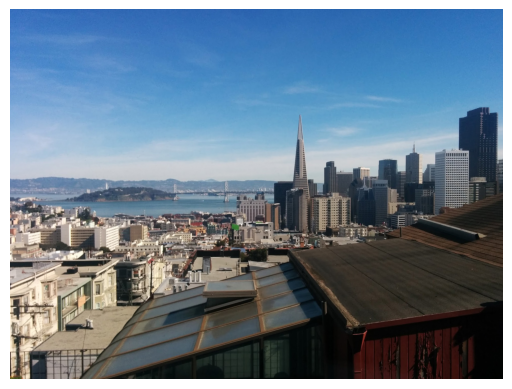

In [3]:
plt.axis('off')
plt.imshow(tf.keras.utils.load_img(base_image_path))

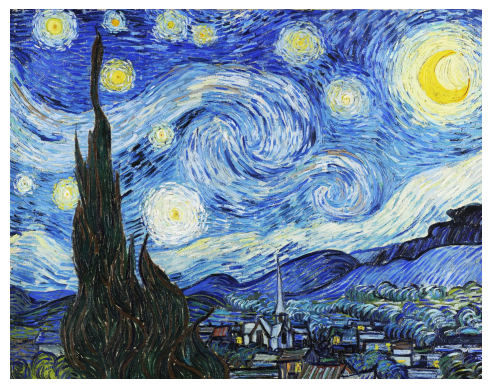

In [4]:
plt.axis('off')
plt.imshow(tf.keras.utils.load_img(style_reference_image_path))

**Auxiliary functions**

In [5]:
original_width, original_height = tf.keras.utils.load_img(base_image_path).size

# here I limit the image to a certain size (either width or height)
max_dim = 500
long_dim = max(original_width, original_height)
scale = max_dim / long_dim

img_height = round(original_height * scale)
img_width = round(original_width * scale)

# to keep the image to its original size, uncomment this
# img_height = original_height
# img_width = original_width

In [6]:
def preprocess_image(image_path):
    img = tf.keras.utils.load_img(                          # load image, specifying the size
        image_path, target_size=(img_height, img_width)
    )
    img = tf.keras.utils.img_to_array(img)                  # to array
    img = np.expand_dims(img, axis=0)                       # add batch dim
    img = tf.keras.applications.vgg19.preprocess_input(img) # specific VGG19 preprocessing
    return img

def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939                       # vgg19.preprocess_input zero centers data by
    img[:, :, 1] += 116.779                       # removing the mean channel value from ImageNet:
    img[:, :, 2] += 123.68                        # here, we simply do this process in reverse
    img = img[:, :, ::-1]                         # vgg19.preprocess_input has BGR channels, reversed here to RGB
    img = np.clip(img, 0, 255).astype("uint8")
    return img

**Using a pretrained VGG19 model to create a feature extractor**

In [7]:
model = tf.keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

# new model that returns all its layers outputs
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers]) 
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [8]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Content loss**

In [9]:
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img)) # squared distance

**Style loss**

For the style loss, we need one concept: the [Gram Matrix](https://en.wikipedia.org/wiki/Gram_matrix).

<!-- ![gram-matrix](images/gram-matrix.png) -->
![gram-matrix](https://github.com/jchwenger/AI/blob/main/8-generative-deep-learning/images/gram-matrix.png?raw=true)

Found in the excellent explanation of the Gram matrix logic by John Whitaker, from the [fast.ai course](https://www.youtube.com/watch?v=PdNHkTLU2oQ&list=PLfYUBJiXbdtRUvTUYpLdfHHp9a58nWVXP&index=12) – in PyTorch –, and the [notebook](https://github.com/fastai/course22p2/blob/master/nbs/16A_StyleTransfer.ipynb)).


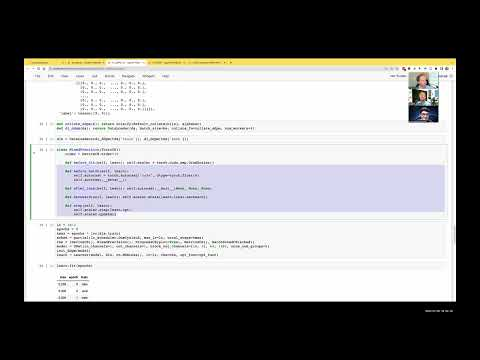

In [10]:
YouTubeVideo("PdNHkTLU2oQ", width=853, height=480, start=3366) # style transfer starts at 1239

In [11]:
def gram_matrix(x):
    """
    Calculate the correlations across features.
    Returns the Gram Matrix, of shape (f, f):
        the correlation score of every feature with itself and all others.
    """
    x = tf.transpose(x, (2, 0, 1))                     # x from (w, h, f) → (f,w,h), features first
    features = tf.reshape(x, (tf.shape(x)[0], -1))     # flatten w & h (-1: "calculate that dimension for me")
    gram = tf.matmul(features, tf.transpose(features)) # matmul: featurewise product & sum over all elements
    return gram

             # ↓ we pass a pre-computed gram matrix for the style image 
def style_loss(style_img_gram, combination_img):
    C = gram_matrix(combination_img) # get gram matrix (feature correlations) for the combination image
    channels = 3
    size = img_height * img_width
         # ↓ the squared difference between the correlations of two matrices
    return tf.reduce_sum(tf.square(style_img_gram - C)) / (4.0 * (channels ** 2) * (size ** 2))
                                                         # ↑ normalisation constant

In [12]:
def gram_matrix_v(x, verbose=False):
    """
    A verbose version of the gram matrix function,
    demonstrating how one can use the print function
    to look at the inner workings of the computation.
    """
    if verbose: 
        print("x shape:         ", x.shape)
    x = tf.transpose(x, (2, 0, 1))
    if verbose: 
        print("x reshaped:      ", x.shape)
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    if verbose: 
        print("features shape:  ", features.shape)    
        print("transposed shape:", tf.transpose(features).shape)    
    gram = tf.matmul(features, tf.transpose(features))
    if verbose: 
        print("gram shape:      ", gram.shape)   
    return gram

gram_matrix_v(preprocess_image(base_image_path)[0], verbose=True)

x shape:          (375, 500, 3)
x reshaped:       (3, 375, 500)
features shape:   (3, 187500)
transposed shape: (187500, 3)
gram shape:       (3, 3)


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1.1690502e+09, 7.5348429e+08, 3.3064717e+08],
       [7.5348429e+08, 6.8935930e+08, 5.9024416e+08],
       [3.3064717e+08, 5.9024416e+08, 8.1177370e+08]], dtype=float32)>

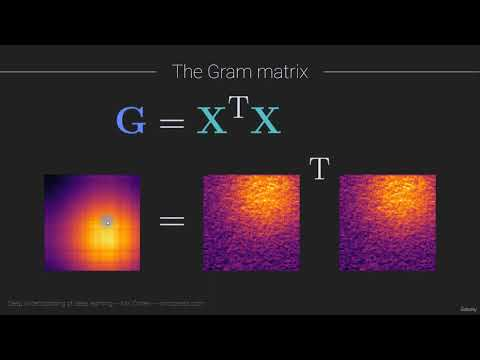

In [13]:
YouTubeVideo('FQiNeuRqZu8', width=853, height=480) # 22.2 The Gram matrix feature activation covariance 

**Total variation loss**

Have a look at the [TensorFlow tutorial](https://www.tensorflow.org/tutorials/generative/style_transfer#total_variation_loss) for a more in-depth explanation.

In [14]:
def total_variation_loss(x):
    """
    Operation on the generated image: 'encourages spatial continuity in
    the generated image, thus avoiding overly pixelated results', DLWP, p. 388.
    """

    # variation: horizontal
    a = tf.square( #                                      ↓ shift by one in the width 
        x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
    ) #        ↑ reduce overall dims as we shift by 1 pixel, also here ↑

    # variation: vertical
    b = tf.square( #                                                        ↓ shift by one in the height
        x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    ) #        ↑ reduce overall dims as we shift by 1 pixel, also here ↑
    
    return tf.reduce_sum(tf.pow(a + b, 1.25)) # somewhat mysterious number here

**Setting up variables, precomputing reference contents & style**

In [23]:
# HYPERPARAMS: TWEAK ME!
content_layer_names = [             # the content layer (could be more than one)
    "block5_conv2",
]

style_layer_names = [               # the style layers
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
                                  # Chollet:
total_variation_weight = 1e-6     # 1e-6
style_weight = 1e-6               # 1e-6
content_weight = 1e-6             # 2.5e-8

num_content_layers = len(content_layer_names)
num_style_layers = len(style_layer_names)

Preproces our content and style reference images, then extract the reference content features and style gram matrices *once*.

In [24]:
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)

content_features = feature_extractor(base_image)

content_targets = {                                         # 1. CONTENT TARGETS:
    layer_name: content_features[layer_name]                #    extract only the content layers we need
    for layer_name, value
    in content_features.items()
    if layer_name in content_layer_names
}

style_features = feature_extractor(style_reference_image)

style_targets = {                                          # 2. STYLE TARGETS:
    layer_name: gram_matrix(style_features[layer_name][0]) #    extract style layers, pre-compute the grams
    for layer_name, value                            # ↑ no batch size!
    in style_features.items()
    if layer_name in style_layer_names
}

**Defining the final loss that you'll minimize**

In [25]:
def compute_loss(combination_image):

    all_combination_features = feature_extractor(combination_image)

    c_loss = tf.zeros(shape=())                                                    # 1. CONTENT LOSS
    for layer_name in content_layer_names:
        base_image_features = content_targets[layer_name][0] # ← no ↓ batch dim    # precomputed content features
        combination_features = all_combination_features[layer_name][0]
        c_loss += content_loss(base_image_features, combination_features)
    c_loss *= content_weight / num_content_layers                                  # weighting and averaging
            # ↑ (all layers with the same weight: could be changed!)

    s_loss = tf.zeros(shape=())                                                    # 2. STYLE LOSS
    for layer_name in style_layer_names:
        style_reference_features = style_targets[layer_name]                       # precomputed style features (grams!)
        combination_features = all_combination_features[layer_name][0]
        s_loss += style_loss(style_reference_features, combination_features)
    s_loss *= style_weight / num_style_layers                                      # weighting and averaging  
            # ↑ (all layers with the same weight: could be changed!)
        
    v_loss = total_variation_weight * total_variation_loss(combination_image)      # 3. VARIATION LOSS
    loss = c_loss + s_loss + v_loss

    return loss, c_loss, s_loss, v_loss # returning everything so I can print values during training!

**Setting up the gradient-descent process**

Docs for TensorFlow [schedules](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules).

In [26]:
@tf.function # make it fast by compiling the function with @tf.function!
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss, c_loss, s_loss, v_loss = compute_loss(combination_image)        
    grads = tape.gradient(loss, combination_image)
    optimizer.apply_gradients([(grads, combination_image)])    
    return loss, c_loss, s_loss, v_loss

learning_rate = 100.

# plain old Adam works fine
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
    beta_1=0.99,
    epsilon=1e-1
)

# To be tried: Chollet has vanilla SGD + learning rate decay:
# optimizer = tf.keras.optimizers.SGD(
#     tf.keras.optimizers.schedules.ExponentialDecay( # gradually lowers the learning rate!
#         initial_learning_rate=learning_rate,
#         decay_steps=100,
#         decay_rate=0.96
#     )
# )

20 | loss: 23,481 content: 1,114 style: 12,805 variation: 9,562 | time: 0.0948
40 | loss: 20,495 content: 1,213 style: 6,761 variation: 12,521 | time: 0.0950
60 | loss: 18,761 content: 1,133 style: 5,037 variation: 12,591 | time: 0.0951
80 | loss: 14,885 content: 1,048 style: 3,042 variation: 10,795 | time: 0.0979
100 | loss: 12,335 content: 997 style: 2,299 variation: 9,039 | time: 0.1004
120 | loss: 10,644 content: 938 style: 1,956 variation: 7,749 | time: 0.0949
140 | loss: 9,521 content: 905 style: 1,661 variation: 6,955 | time: 0.0993
160 | loss: 8,778 content: 849 style: 1,494 variation: 6,435 | time: 0.0943
180 | loss: 8,232 content: 787 style: 1,402 variation: 6,042 | time: 0.0938
200 | loss: 7,771 content: 745 style: 1,262 variation: 5,765 | time: 0.0967


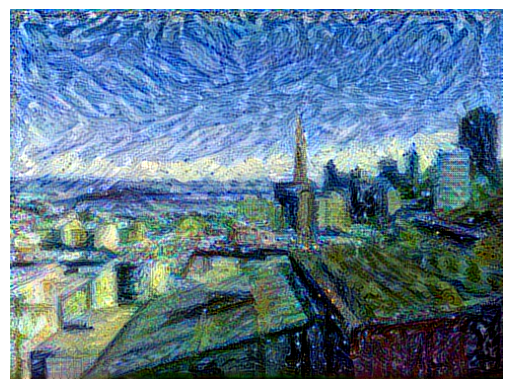

220 | loss: 7,327 content: 693 style: 1,190 variation: 5,444 | time: 0.1001
240 | loss: 6,961 content: 649 style: 1,181 variation: 5,131 | time: 0.0997
260 | loss: 6,616 content: 616 style: 1,157 variation: 4,842 | time: 0.0981
280 | loss: 6,319 content: 580 style: 1,173 variation: 4,565 | time: 0.0981
300 | loss: 6,079 content: 551 style: 1,194 variation: 4,333 | time: 0.1025
320 | loss: 5,881 content: 529 style: 1,214 variation: 4,138 | time: 0.0953
340 | loss: 5,717 content: 507 style: 1,209 variation: 4,001 | time: 0.1003
360 | loss: 5,571 content: 484 style: 1,219 variation: 3,868 | time: 0.0994
380 | loss: 5,444 content: 461 style: 1,217 variation: 3,766 | time: 0.1008
400 | loss: 5,334 content: 442 style: 1,216 variation: 3,676 | time: 0.1004


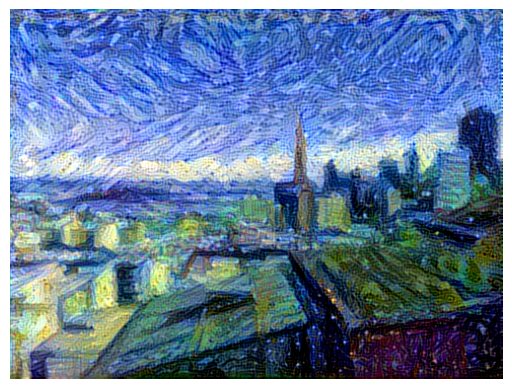

In [27]:
combination_image = tf.Variable(preprocess_image(base_image_path)) # THE IMAGE WE LEARN (COMBINATION)

iterations = 400    # Chollet: 4000
display_every = 200
print_every = 20
save_intermediate = False

for i in range(1, iterations + 1):
    start = time.time()
    loss, c_loss, s_loss, var_loss = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    end = time.time()

    if i % print_every == 0:
        l = loss.numpy().item()
        c_l = c_loss.numpy().item()
        s_l = s_loss.numpy().item()
        v_l = var_loss.numpy().item()
        print(f"{i} | loss: {l:,.0f} content: {c_l:,.0f} style: {s_l:,.0f} variation: {v_l:,.0f} | time: {end-start:.4f}")

    if i % display_every == 0:
        img = deprocess_image(combination_image.numpy())
        if save_intermediate:
            fname = basedir / f"combination_image_at_iteration_{i}.png"
            tf.keras.utils.save_img(fname, img)
        plt.axis('off')
        plt.imshow(img)
        plt.show()
    
img = deprocess_image(combination_image.numpy())
fname = basedir / f"combination_image_at_iteration_{iterations}.png"
tf.keras.utils.save_img(fname, img)

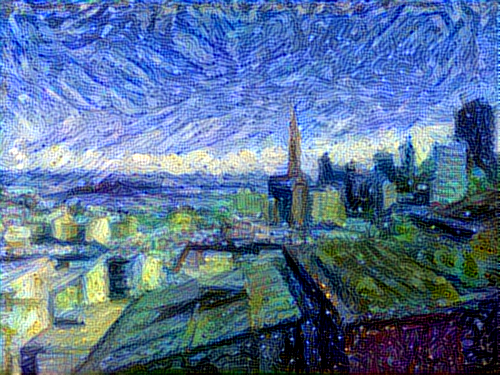

In [28]:
Image.open(fname)

### Tutorials

Have a look at the [official TensorFlow tutorial](https://www.tensorflow.org/tutorials/generative/style_transfer), it contains useful additional information! 

There are various differences in the implementation that make the two not a direct comparison (for instance looking at the numbers used for the various weights). 

However, understanding those differences and being able to integrate the two approaches into one is a *very* good exercise!

Also, have a look at Andrew Ng's videos below!

### Experiments

The kind of experimentations you can do with this are the same as with Deep Dream:
- Experiment with different **layers** and **hyperparameters**;
- Try it with a different network ([list of `tf.keras.applications` models](https://www.tensorflow.org/api_docs/python/tf/keras/applications));
- Refactor the code so that it is *really* easy for you to change parameters and rerun the code, allowing you to explore the space of possibilites as smoothly as possible.
- Save and visualise images at **intermediate steps**. You could even try a small learning rate, save **all** intermediate steps, then combining the results into videos or gifs.
- It might be nice to implement a **systematic** search of the hyperparameter space for interesting effects and to build intuition.
- One nice experiment could be try the learning with only one, or two, of the losses (or at least trying to decrease two), to see their different influence.

#### Note

Beware, depending on the values you choose, your overall loss may blow up to infinity (if you see 'nan' in the loss, you've hit it). I haven't implemented safety checks, that could be done, and instead I just tweaked the parameters. 

### 12.2.2 Wrapping up

- Style transfer adorns the contents of a target image with style of a reference image;
- Content can be captured by the **high-level activations** of a convnet;
- Style can be captured by the **internal correlations of the activations** of different layers of a convnet;
- We **learn the combination image**: an optimization process with a special loss;
- There are many variants and refinements.

### References

[Gatis et al., "A Neural Algorithm of Artistic Style"](https://arxiv.org/abs/1508.06576)

Andrew Ng's videos on Neural Style Transfer (as part of [this playlist](https://www.youtube.com/watch?v=R39tWYYKNcI&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=37)):

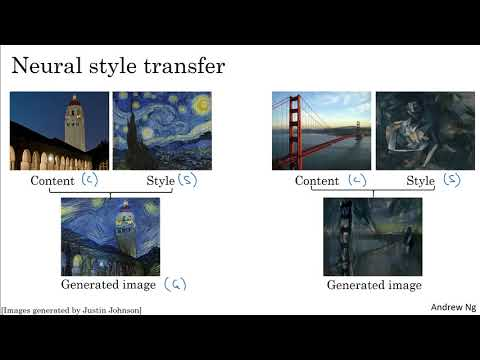

In [29]:
YouTubeVideo('R39tWYYKNcI', width=853, height=480) # Andrew Ng, C4W4L06 What is neural style transfer?

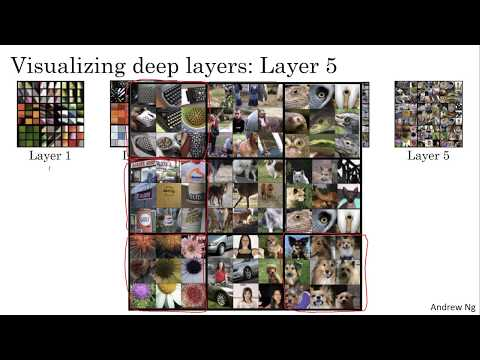

In [30]:
YouTubeVideo('ChoV5h7tw5A', width=853, height=480) # Andrew Ng, C4W4L07 What are deep CNs learning?

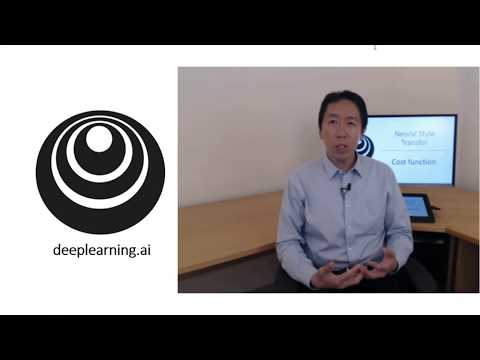

In [31]:
YouTubeVideo('xY-DMAJpIP4', width=853, height=480) # Andrew Ng, C4W4L08 Cost Function

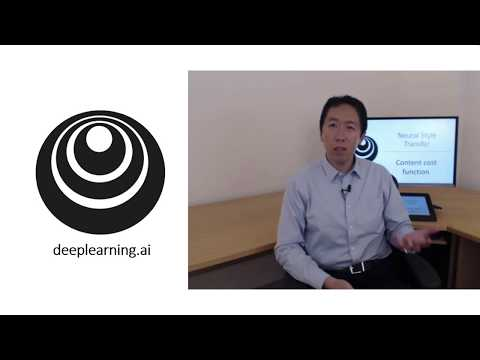

In [32]:
YouTubeVideo('b1I5X3UfEYI', width=853, height=480) # Andrew Ng, C4W4L09 Content Cost Function

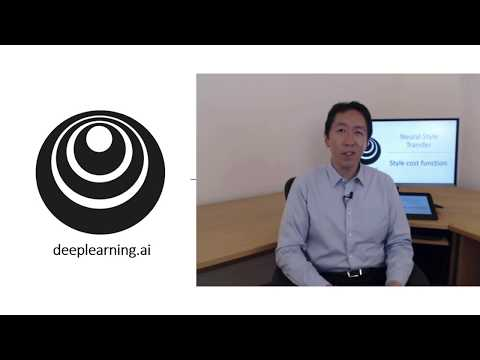

In [33]:
YouTubeVideo('QgkLfjfGul8', width=853, height=480) # Andrew Ng, C4W4L10 Style Cost Function